# Introduction

Term deposits are a major source of income for a bank. A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term. The bank has various outreach plans to sell term deposits to their customers such as email marketing, advertisements, telephonic marketing, and digital marketing.

Telephonic marketing campaigns still remain one of the most effective way to reach out to people. However, they require huge investment as large call centers are hired to actually execute these campaigns. Hence, it is crucial to identify the customers most likely to convert beforehand so that they can be specifically targeted via call.

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).<br>
https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from imblearn import under_sampling, over_sampling
import statsmodels.api as sm

# Load and Decsribe Data

In [2]:
df = pd.read_csv('../data/train.csv',sep=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Detailed Column Description

**Bank client data:**
<br>
1. `age` (numeric)
2. `job` : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
3. `marital` : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. `education` (categorical: "unknown","secondary","primary","tertiary")
5. `default`: has credit in default? (binary: "yes","no")
6. `balance`: average yearly balance, in euros (numeric)
7. `housing`: has housing loan? (binary: "yes","no")
8. `loan`: has personal loan? (binary: "yes","no")
<br>
**Related with the last contact of the current campaign:**
<br>
1. `contact`: contact communication type (categorical: "unknown","telephone","cellular")
2. `day`: last contact day of the month (numeric)
3. `month`: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
4. `duration`: last contact duration, in seconds (numeric)
<br>
**Other attributes:**
1. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
2. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
3. `previous`: number of contacts performed before this campaign and for this client (numeric)
4. `poutcome`: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
<br>
**Output variable (desired target):**<br>
`y` - has the client subscribed a term deposit? (binary: "yes","no")

## Numerical Data

In [4]:
num_dtypes = ['int16','int32','int64','float16','float32','float64']

num_df = df.select_dtypes(include=num_dtypes)
numericals = num_df.columns

print(numericals)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [5]:
num_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


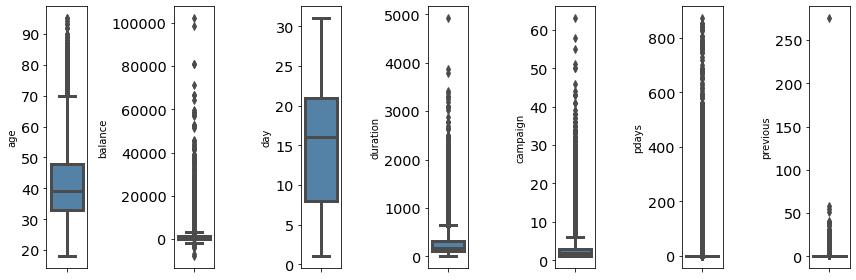

In [6]:
for i in range(0, len(numericals)):
    plt.subplot(1, len(numericals), i+1)
    sns.boxplot(y=df[numericals[i]], color='steelblue', orient='v')
    plt.tight_layout()

Almost all numerical data are not normally distributed.

## Categorical Data

In [7]:
cat_dtypes = ['object']

cat_df = df.select_dtypes(include=cat_dtypes)
categoricals = cat_df.columns

print(categoricals)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


In [8]:
cat_df.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


`job` has many unique values and there is an 'unknown' value on `poutcome` which has the most number.

## Target Imbalance

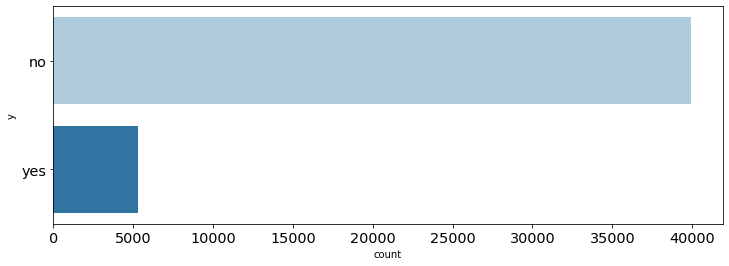

In [9]:
sns.countplot(data=df, y='y', palette='Paired');

Target is imbalance dominated by no value. This will affect the model in predicting the label.

# Data Analysis and Preparation

## Missing Value

There is no missing value in every feature.

In [10]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,age,0
1,job,0
2,marital,0
3,education,0
4,default,0
5,balance,0
6,housing,0
7,loan,0
8,contact,0
9,day,0


## Duplicated Data

There is no duplicated data, each columns represent unique transaction from different customer.

In [11]:
df.duplicated().any()

False

## Feature Engineering

### Grouping Job

`job` can be grouped into more general data so that the number of unique values is not too much.

In [12]:
list_jobgroup = []

for i, x in df.iterrows():
    if x['job'] == 'management':
        jobgroup = 'employee'
    elif x['job'] == 'technician':
        jobgroup = 'employee'
    elif x['job'] == 'admin.':
        jobgroup = 'employee'
    elif x['job'] == 'services':
        jobgroup = 'employee'      
    elif x['job'] == 'blue-collar':
        jobgroup = 'manual labor'
    elif x['job'] == 'housemaid':
        jobgroup = 'manual labor'
    elif x['job'] == 'self-employed':
        jobgroup = 'self-employed'
    elif x['job'] == 'entrepreneur':
        jobgroup = 'self-employed'
    elif x['job'] == 'retired':
        jobgroup = 'retired'
    elif x['job'] == 'student':
        jobgroup = 'student'
    elif x['job'] == 'unemployed':
        jobgroup = 'unemployed'
    else:
        jobgroup = 'unknown'
    list_jobgroup.append(jobgroup)

df['job_group'] = list_jobgroup

### Label Encoding

`default`, `housing`, and `loan` are features with two values, 'yes' and 'no', label encoding will be performed in these features. From these three features, it shows that customers who do not have a `default`, `housing`, or `loan` tend to open a deposit account.

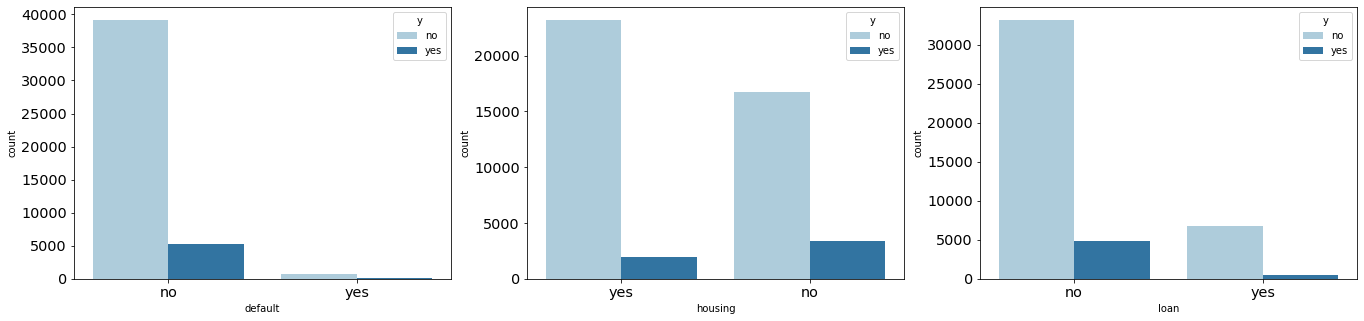

In [13]:
fig, ax = plt.subplots(1,3,figsize=(23, 5))

sns.countplot(data=df, x='default', hue='y', ax = ax[0], palette='Paired')
sns.countplot(data = df, x = 'housing', hue = 'y', ax = ax[1], palette='Paired')
sns.countplot(data = df, x = 'loan', hue = 'y', ax = ax[2], palette='Paired');

In [14]:
df['default'].replace('no', 0, inplace = True)
df['default'].replace('yes', 1, inplace = True)
df['housing'].replace('no', 0, inplace = True)
df['housing'].replace('yes', 1, inplace = True)
df['loan'].replace('no', 0, inplace = True)
df['loan'].replace('yes', 1, inplace = True)

### Handling unknown value

'unknown' value was found in `job_group`, `education`, `contact`, and `poutcome`.

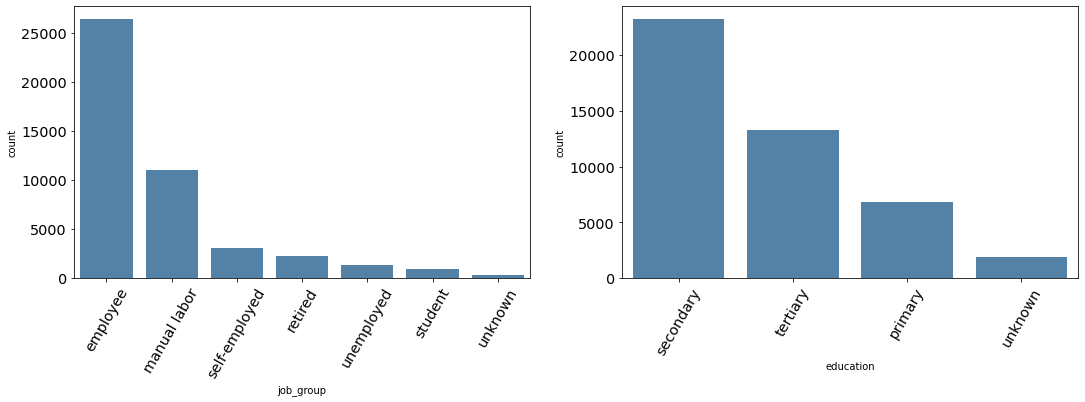

In [15]:
fig, ax = plt.subplots(1,2,figsize=(18, 5))

sns.countplot(data=df, x='job_group', ax = ax[0], color='steelblue', order=df["job_group"].value_counts().index).tick_params(axis='x', rotation=60)
sns.countplot(data = df, x = 'education', ax = ax[1], color='steelblue', order=df["education"].value_counts().index).tick_params(axis='x', rotation=60);

'unknown' value in `education` and `job_group` is less than 5%, so the value will be replaced with the mode to avoid bias.

In [16]:
df['job_group'].replace(['unknown'],df['job_group'].mode(),inplace = True)
df['education'].replace(['unknown'],df['education'].mode(),inplace = True)

Customers with `job_group` employee have more numbers of opening deposit account.

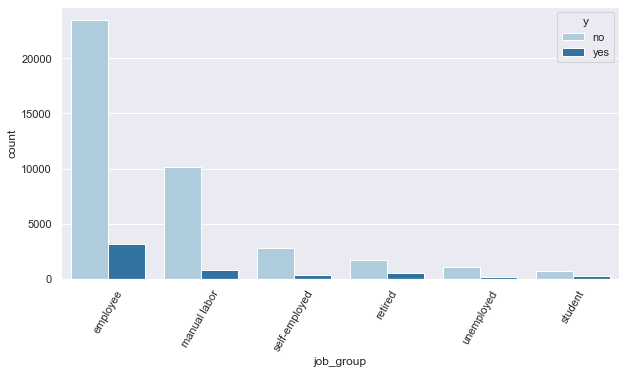

In [17]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
job = sns.countplot(x="job_group", data = df, hue = "y", order = df["job_group"].value_counts().index, palette="Paired")
job.tick_params(axis='x', rotation=60)
plt.show()

Customers with `education` 'secondary' and 'tertiary' have the same numbers of opening deposit account, with 'tertiary' have higher conversion rate.

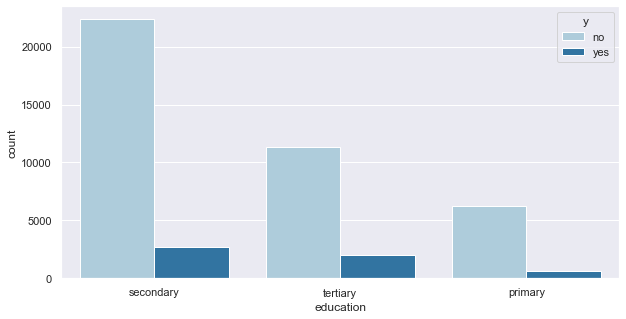

In [18]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
sns.countplot(x="education", data = df, hue = "y", order = df["education"].value_counts().index, palette="Paired")
plt.show()

'unknown' values in `contact` and `poutcome` have a large value, so replace it with mode might make the data speak differently. Here, can be assumed that 'unknown' in `contact` means that this customers have been exposed by campaign with another type of marketing such as email marketing, advertising, or digital marketing, without marketing team reach out personally to them. Whereas, 'unknown' values in `poutcome` can be assumed that customers never been exposed to another campaign before this campaign.

### Grouping Contact

Customers that have been contacted personally with team marketing tend to open a deposit account. Customer that have been contacted with 'cellular' have more in numbers because it is easier to contact people by phone cellular than telephone. When viewed from the proportion between those who open and not open accounts from customers with `contact` 'cellular' and 'telephone', the number between the two is not different. Thus, it can be said that, whether customers are contacted with 'cellular' or 'telephone' did not have any impact on the conversion rate. <br><br>
'cellular' and 'telephone' can be grouped into 'phone' then processed with label encoding.

<AxesSubplot:xlabel='contact', ylabel='count'>

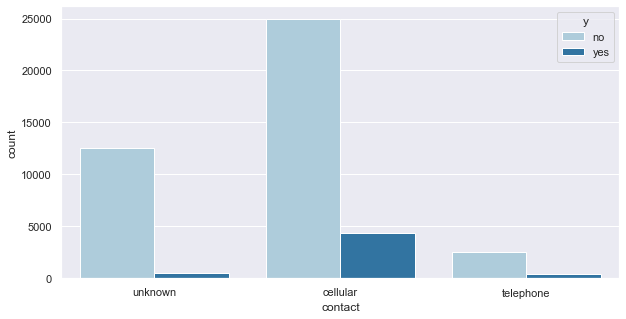

In [19]:
sns.countplot(data=df, x='contact', hue = 'y', palette='Paired')

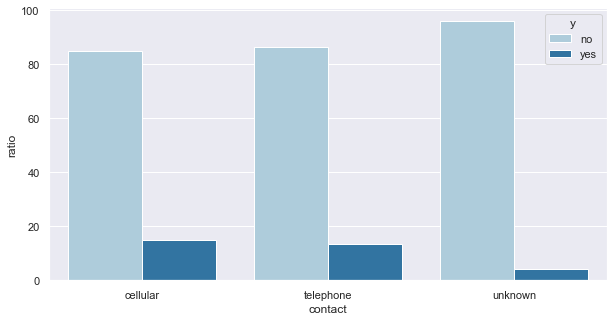

In [20]:
df_contact = df.copy()
df_contact_group = df_contact.groupby(['contact', 'y'])['job'].count().reset_index()
df_contact_group.columns = ['contact', 'y', 'count']
df_contact_group['total_per_count'] = df_contact_group.groupby(['contact'])['count'].transform('sum')
df_contact_group['ratio'] = (df_contact_group['count']/df_contact_group['total_per_count'])*100

sns.barplot(data = df_contact_group, x = 'contact', y = 'ratio', hue = 'y', palette='Paired');

In [21]:
df['contact_group']=df['contact'].apply(lambda x: 'phone' if  (x == 'telephone' or x == 'cellular') else 'unknown')
df['contact_group'].replace('unknown', 0, inplace = True)
df['contact_group'].replace('phone', 1, inplace = True)

### Remove invalid rows

If `poutcome` 'unknown' means the customers never exposed on other campaign, `pdays` must be -1 (client was not previously contacted). Also makes sure, that when `pdays` -1, values of `previous` is 0. Because the number of invalid data based on those rule are not many, the invalid data will be removed.

In [22]:
df[(df['poutcome']=='unknown') & (df['pdays']!=-1)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,job_group,contact_group
40658,61,retired,married,tertiary,0,3140,1,1,cellular,6,aug,975,4,98,1,unknown,yes,retired,1
41821,39,management,married,tertiary,0,184,0,0,cellular,15,oct,206,1,168,5,unknown,no,employee,1
42042,26,admin.,single,secondary,0,338,0,0,cellular,29,oct,209,1,188,2,unknown,yes,employee,1
43978,30,technician,single,secondary,0,254,1,1,cellular,24,jun,167,3,416,2,unknown,no,employee,1
45021,37,management,married,secondary,0,209,0,0,cellular,14,oct,183,3,528,7,unknown,no,employee,1


In [23]:
df[(df['pdays']==-1) & (df['previous']!=0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,job_group,contact_group


In [24]:
df = df[ ~((df['poutcome']=='unknown') & (df['pdays']!=-1))]

`poutcome` dominated with 'unknown' values, means bank tend to contact new customers who never been exposed to another campaign. However, when viewed from proportion, customers who `success` in previous campaign tend to open account for this campaign.

<AxesSubplot:xlabel='poutcome', ylabel='count'>

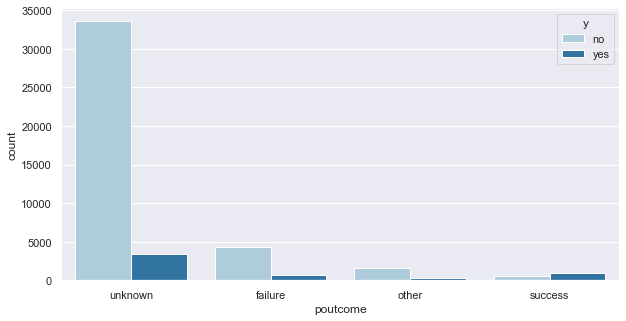

In [25]:
sns.countplot(data=df, x='poutcome', hue = 'y', palette='Paired')

### One Hot Encoding

In [26]:
cats_oh = ['job_group','marital','education','poutcome']
for cat in cats_oh:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

df.drop(cats_oh, axis=1, inplace=True)
df.sample(10,random_state=42)
df.head(3)

,age,job,default,balance,housing,loan,contact,day,month,duration,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,0,2143,1,0,unknown,5,may,261,...,0,1,0,0,0,1,0,0,0,1
1,44,technician,0,29,1,0,unknown,5,may,151,...,0,0,1,0,1,0,0,0,0,1
2,33,entrepreneur,0,2,1,1,unknown,5,may,76,...,0,1,0,0,1,0,0,0,0,1


### Change duration seconds to minutes

In [27]:
df['duration'] = df['duration']/60

### Correlation

Text(0.5, 1.0, 'Features Correlation')

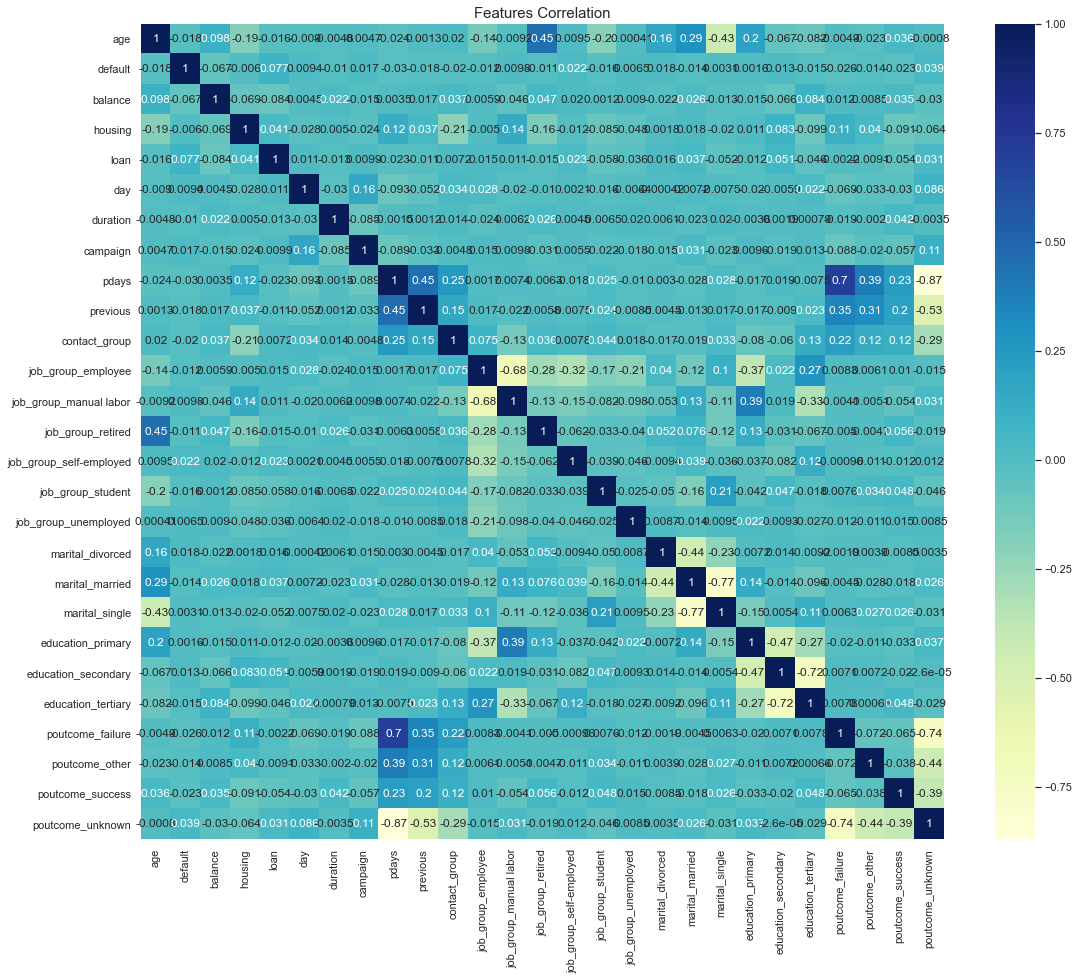

In [28]:
plt.figure(figsize = (18, 15))
sns.heatmap(df.corr(), cmap = 'YlGnBu', annot = True)
plt.title("Features Correlation", fontsize = 15)

Features with strong correlation are `pdays` with `poutcome_unknown`, will drop `pdays` to prevent multicollinearity.

### Feature Selection

In [29]:
df.drop(['job', 'contact', 'day', 'month', 'pdays'], axis=1, inplace=True)
df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'previous', 'y', 'contact_group', 'job_group_employee',
       'job_group_manual labor', 'job_group_retired',
       'job_group_self-employed', 'job_group_student', 'job_group_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [30]:
df.describe()

,age,default,balance,housing,loan,duration,campaign,previous,contact_group,job_group_employee,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,...,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000,45206.000000
mean,40.936469,0.018029,1362.331483,0.555855,0.160200,4.302552,2.763881,0.580012,0.711985,0.589833,...,0.115184,0.601933,0.282883,0.151551,0.554263,0.294187,0.108415,0.040703,0.033425,0.817458
std,10.618553,0.133056,3044.904583,0.496876,0.366795,4.291986,3.098164,2.303257,0.452843,0.491869,...,0.319247,0.489505,0.450405,0.358589,0.497052,0.455681,0.310907,0.197602,0.179745,0.386295
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,1.716667,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,3.000000,2.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,5.316667,3.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,81.966667,63.000000,275.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
